합성 신경망 중 일부는 주요 주제(ex집)에 관련 있고 일부는 스타일(ex인테리어)에 더 관련있다  
contents의 양과 style의 양을 조절하여 이미지를 변형할 수 있음  


In [ ]:
import cv2
a = cv2.imread(content_image_path)
a.shape

(448, 598, 3)

In [ ]:
content_image.shape, style_image.shape

(TensorShape([1, 224, 224, 3]), TensorShape([1, 224, 224, 3]))

80134624/80134624 [==============================] - 1s 0us/step
Epoch 25 | content loss : 6542.6416015625 | style loss : 19110559744.0 | total loss : 3822111948800.0


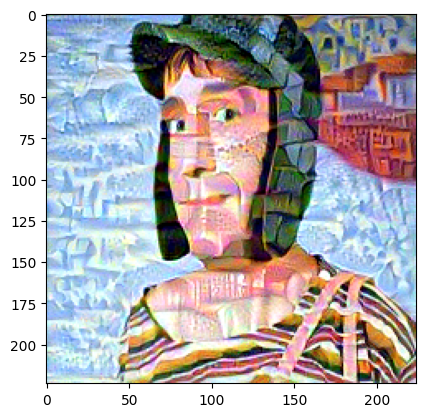

Epoch 50 | content loss : 7460.8896484375 | style loss : 8415421440.0 | total loss : 1683084279808.0


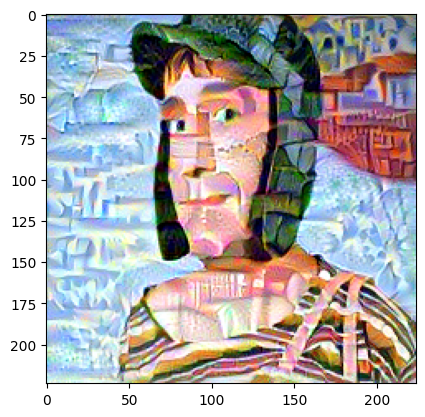

Epoch 75 | content loss : 7997.25830078125 | style loss : 5644832768.0 | total loss : 1128966520832.0


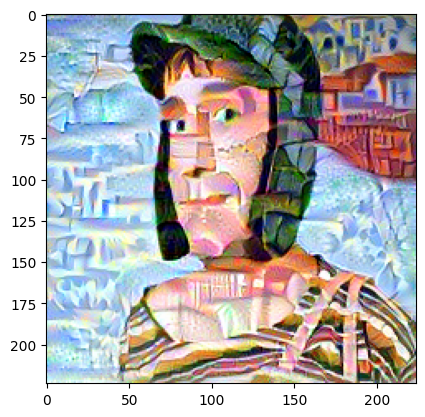

Epoch 100 | content loss : 8320.611328125 | style loss : 4439521280.0 | total loss : 887904272384.0


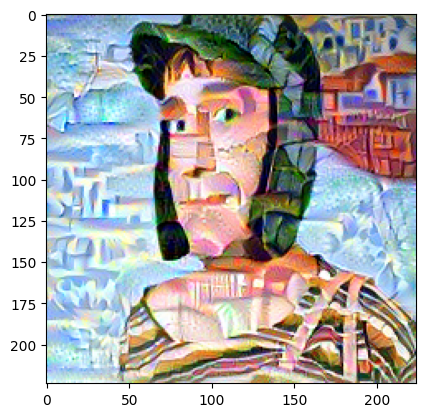

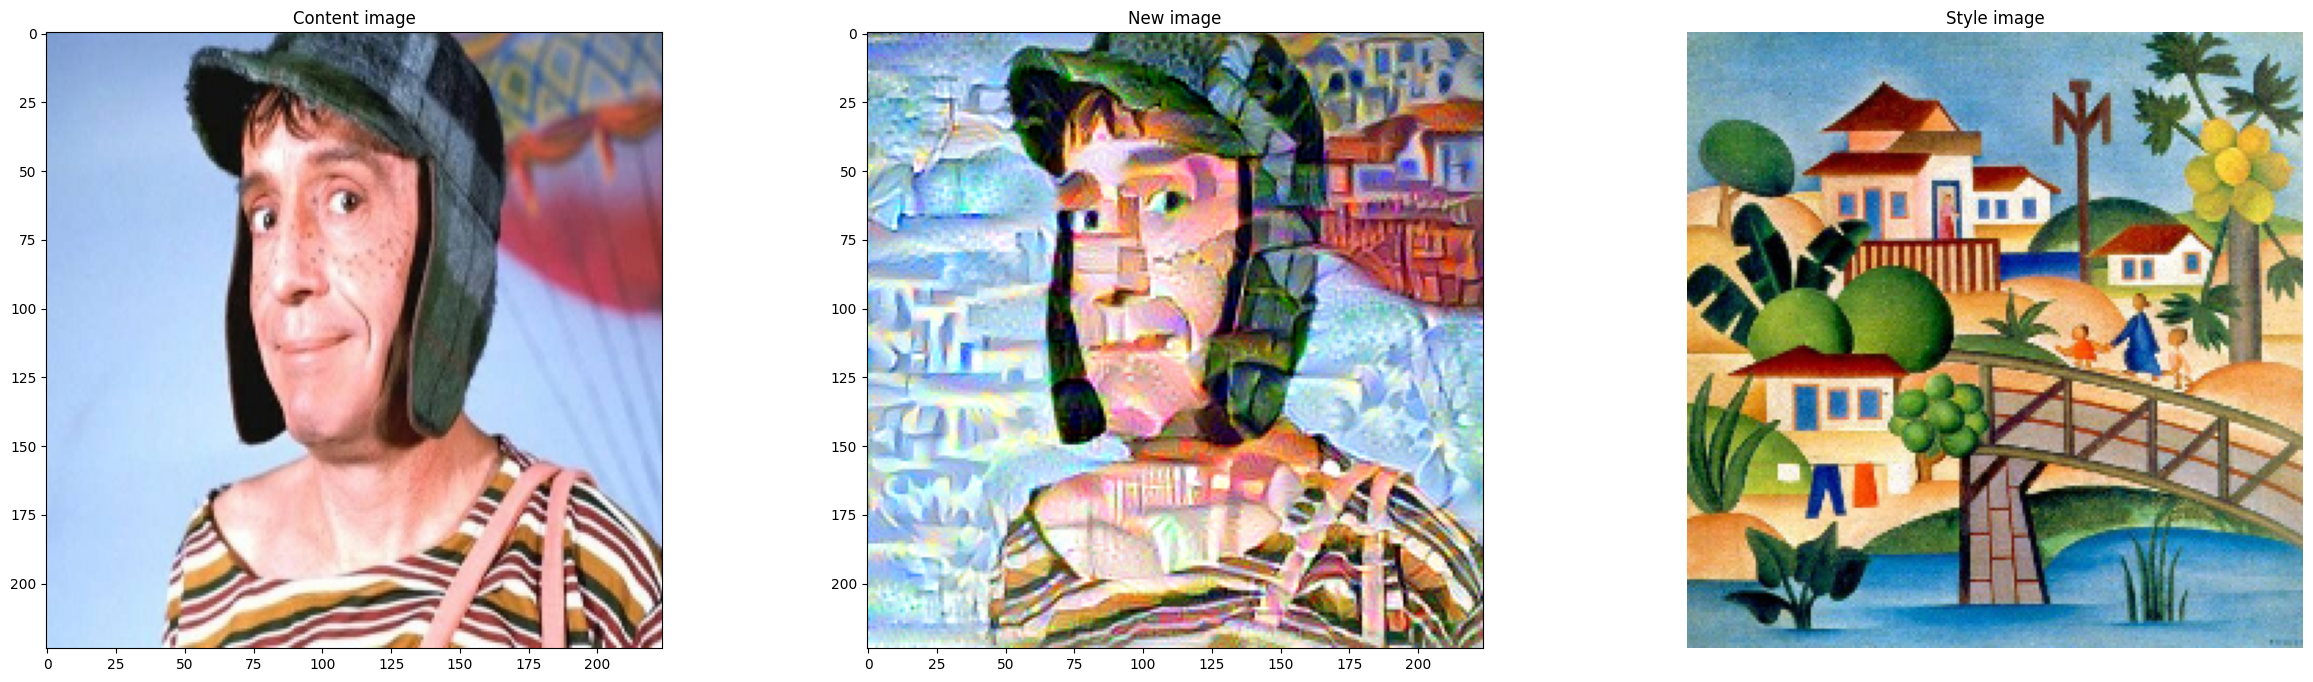

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

# Gram Matrix 계산
def gram(layer_activation):
    result = tf.linalg.einsum('bijc,bijd -> bcd', layer_activation, layer_activation)
    input_shape = tf.shape(layer_activation)
    num_locations = tf.cast(input_shape[1] * input_shape[2], tf.float32)
    return result / num_locations

# VGG 모델의 특정 레이어들을 가져와 새로운 모델을 만드는 함수
def vgg_layers(layer_names):
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False
    outputs = [vgg.get_layer(name).output for name in layer_names]
    network = tf.keras.Model(inputs=[vgg.input], outputs=outputs)
    return network

# 스타일 및 콘텐츠 특징을 추출하는 모델 정의
class StyleContentModel(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super().__init__()
        self.vgg = vgg_layers(style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False

    def call(self, inputs):
        inputs = inputs * 255.0
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed_input)
        style_outputs = outputs[:self.num_style_layers]
        content_outputs = outputs[self.num_style_layers:]

        style_outputs = [gram(style_output) for style_output in style_outputs]
        content_dict = {content_name: value for content_name, value in zip(self.content_layers, content_outputs)}
        style_dict = {style_name: value for style_name, value in zip(self.style_layers, style_outputs)}

        return {'content': content_dict, 'style': style_dict}

# 이미지 경로
content_image_path = "/content/drive/MyDrive/ColabDrive/Computer_Vision_Masterclass/Images/chaves.jpeg"
style_image_path = '/content/drive/MyDrive/ColabDrive/Computer_Vision_Masterclass/Images/tarsila_amaral.jpg'

# 이미지 불러오기 및 전처리
def load_and_preprocess_image(image_path):
    image = tf.keras.preprocessing.image.load_img(image_path)
    image = tf.keras.preprocessing.image.img_to_array(image)
    image = image / 255.0
    image = tf.image.resize(image, (224, 224))  # 이미지 크기를 모델 입력 크기로 조정
    image = image[tf.newaxis, :]
    return image

# 콘텐츠 및 스타일 이미지 로드 및 전처리
content_image = load_and_preprocess_image(content_image_path)
style_image = load_and_preprocess_image(style_image_path)

# 콘텐츠 및 스타일 레이어 정의
content_layers = ['block5_conv2']
style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']

# 콘텐츠 및 스타일을 추출하는 모델 인스턴스화
extractor = StyleContentModel(style_layers, content_layers)

# 스타일 및 콘텐츠 특징 추출
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

# 생성될 이미지 변수 정의
new_image = tf.Variable(content_image)

# Loss 가중치 설정
style_weight = 1000
content_weight = 1

# Optimizer 설정
optimizer = tf.optimizers.Adam(learning_rate=0.02)

# 학습
epochs = 100
print_every = 25
for epoch in range(epochs):
    with tf.GradientTape() as tape:
        tape.watch(new_image)
        outputs = extractor(new_image)
        content_outputs = outputs['content']
        style_outputs = outputs['style']

        content_loss = tf.add_n([tf.reduce_mean((content_outputs[name] - content_targets[name]) ** 2)
                                 for name in content_outputs.keys()])

        style_loss = tf.add_n([tf.reduce_mean((style_outputs[name] - style_targets[name]) ** 2)
                               for name in style_outputs.keys()])

        total_loss = content_loss * content_weight / len(content_layers) + \
                     style_loss * style_weight / len(style_layers)

    gradient = tape.gradient(total_loss, new_image)
    optimizer.apply_gradients([(gradient, new_image)])
    new_image.assign(tf.clip_by_value(new_image, 0.0, 1.0))

    if (epoch + 1) % print_every == 0:
        print(f'Epoch {epoch + 1} | content loss : {content_loss} | style loss : {style_loss} | total loss : {total_loss}')
        plt.imshow(tf.squeeze(new_image, axis=0))
        plt.show()

# 결과 시각화
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 8))
ax1.imshow(tf.squeeze(content_image, axis=0))
ax1.set_title('Content image')
ax2.imshow(tf.squeeze(new_image))
ax2.set_title('New image')
ax3.imshow(tf.squeeze(style_image))
ax3.set_title('Style image')
plt.axis('off')
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
tf.__version__

'2.15.0'

In [ ]:
network = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

80134624/80134624 [==============================] - 1s 0us/step


In [ ]:
network.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
content_image = tf.keras.preprocessing.image.load_img("/content/drive/MyDrive/ColabDrive/Computer_Vision_Masterclass/Images/chaves.jpeg")

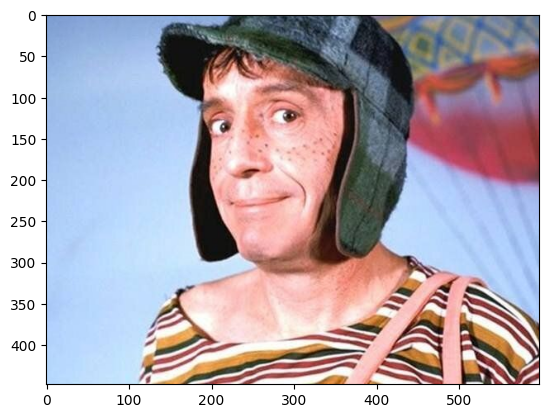

In [ ]:
plt.imshow(content_image)

In [ ]:
content_image = tf.keras.preprocessing.image.img_to_array(content_image)
content_image = content_image / 255
content_image.max(), content_image.min()

(1.0, 0.0)

In [ ]:
content_image = content_image[tf.newaxis, :]
content_image.shape

(1, 448, 598, 3)

In [ ]:
style_image =tf.keras.preprocessing.image.load_img('/content/drive/MyDrive/ColabDrive/Computer_Vision_Masterclass/Images/tarsila_amaral.jpg')

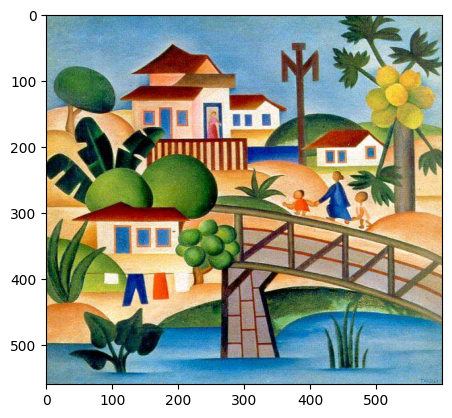

In [ ]:
plt.imshow(style_image)

In [ ]:
style_image = tf.keras.preprocessing.image.img_to_array(style_image)
style_image = style_image/255
style_image = style_image[tf.newaxis, :]
style_image.shape

(1, 560, 600, 3)

In [ ]:
contents_layer=['block5_conv2']
style_layer = ['block1_conv1','block2_conv1','block3_conv1','block4_conv1','block5_conv1']
num_content_layer =len(contents_layer)
num_style_layer =len(style_layer)


In [ ]:
style_extractor = vgg_layers(style_layer)
style_outputs = style_extractor(style_image)

[style_outputs[i] for i in range(5)]

[<tf.Tensor: shape=(1, 560, 600, 64), dtype=float32, numpy=
 array([[[[0.0000000e+00, 1.0877684e-01, 6.1876789e-02, ...,
           4.7548783e-01, 4.9462211e-01, 1.5644574e-01],
          [0.0000000e+00, 2.0908591e-01, 3.7850654e-01, ...,
           1.7786777e-01, 1.4868841e+00, 1.1423521e+00],
          [0.0000000e+00, 2.0027557e-01, 3.8594389e-01, ...,
           1.3720292e-01, 1.5296972e+00, 1.1784816e+00],
          ...,
          [0.0000000e+00, 3.3374479e-01, 5.1606625e-01, ...,
           0.0000000e+00, 1.6996145e+00, 1.3344207e+00],
          [0.0000000e+00, 3.4465253e-01, 5.2247036e-01, ...,
           0.0000000e+00, 1.7055959e+00, 1.3397942e+00],
          [7.8262198e-01, 4.2381790e-01, 7.7576441e-01, ...,
           4.4776672e-01, 2.4687252e+00, 2.3798752e+00]],
 
         [[0.0000000e+00, 1.1056375e-01, 0.0000000e+00, ...,
           8.2489014e-02, 0.0000000e+00, 0.0000000e+00],
          [6.3421291e-01, 2.3642045e-01, 3.5782573e-01, ...,
           0.0000000e+00, 5.8060557

In [ ]:
#gram matrix -> #활성화값을 입력받아 이미지의 스타일 특성을 포착
#bijc , bijd -> bcd
#b는 배치 크기, i와 j는 행렬 크기, c와 d는 행렬 원소의 채널 수
#i와 j번째의 원소의 채널이 3이라면 [a, b, c]이런 형식
#만약 첫번째 행렬의 원소가 [a, b, c]이고 두번째 행렬의 원소가 [d,e,f]라면
#원소를 [a*d, b*e, c*f]로 계산
#그 후 같은 모든 i,j 원소의 같은 채널을 더함
#b = 1, c = 3, d = 3

def gram(layer_activation):
  result = tf.linalg.einsum('bijc,bijd -> bcd', layer_activation, layer_activation)
  input_shape=tf.shape(layer_activation)
  num_locations=tf.cast(input_shape[1]*input_shape[2], tf.float32)

  return result/num_locations

In [ ]:
def vgg_layers(layer_names):
  vgg = tf.keras.applications.VGG19(include_top= False, weights='imagenet')
  vgg.trainable = False
  outputs = [vgg.get_layer(name).output for name in layer_names]
  network = tf.keras.Model(inputs=[vgg.input],
outputs=outputs)
  return network

In [ ]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super().__init__()
    self.vgg = vgg_layers(style_layers + content_layers) # 이 함수의 의미는? layer가 담겨있는 리스트를 합쳐서 모든 레이어에 대한 결과값을 얻음
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    inputs = inputs * 255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs) #-127.5 ~ 127.5 -> vgg전용 전처리
    outputs = self.vgg(preprocessed_input)
    style_outputs = outputs[:self.num_style_layers]
    content_outputs = outputs[self.num_style_layers:] #init()의 덧셈 순서에 관한 것

    style_outputs = [gram(style_output) for style_output in style_outputs] #-> 왜 style만 gram 적용? -> content는 객체의 위치나 크기가 중요, style은 추상적인 질감이나 패턴이 중요
    content_dict = {content_name : value for content_name, value in zip(self.content_layers, content_outputs)}
    style_dict = {style_name : value for style_name, value in zip(self.style_layers, style_outputs)}

    return {'content':content_dict, 'style':style_dict}


In [ ]:
extractor = StyleContentModel(style_layer, contents_layer)

In [ ]:
results = extractor.call(content_image)
len(results['content']), len(results['style'])

(1, 5)

In [ ]:
#style_targets = extractor(style_image)['style']
#content_targets = extractor(content_image)['content'] #tf.keras.models.Model 상속받은 객체에서 자동으로 call 실행
style_targets = results['style']
content_targets = results['content']
new_image = tf.Variable(content_image) #값은 바뀌지 않음, 형식만 바뀐 듯 -> tape에서 기록가능

In [ ]:
style_targets

{'block1_conv1': <tf.Tensor: shape=(1, 64, 64), dtype=float32, numpy=
 array([[[1924.9276  ,  343.26648 ,  387.0994  , ...,  455.05984 ,
           400.3475  ,  823.4776  ],
         [ 343.26648 , 6202.027   , 3726.9417  , ...,   78.77174 ,
           365.5091  , 1117.4033  ],
         [ 387.0994  , 3726.9417  , 2418.729   , ...,   12.140039,
           388.4225  , 1002.9649  ],
         ...,
         [ 455.05984 ,   78.77174 ,   12.140039, ..., 5226.025   ,
           319.6596  ,  159.05629 ],
         [ 400.3475  ,  365.5091  ,  388.4225  , ...,  319.6596  ,
          1147.3447  ,  977.68384 ],
         [ 823.4776  , 1117.4033  , 1002.9649  , ...,  159.05629 ,
           977.68384 , 1443.4775  ]]], dtype=float32)>,
 'block2_conv1': <tf.Tensor: shape=(1, 128, 128), dtype=float32, numpy=
 array([[[2.0394193e+03, 2.5556850e+02, 2.5324043e+01, ...,
          1.1676351e+03, 1.1914012e+03, 4.1859818e+02],
         [2.5556850e+02, 3.9261375e+04, 9.0589023e+03, ...,
          2.4046754e+04, 

In [ ]:
print(new_image)
print(content_image)

<tf.Variable 'Variable:0' shape=(1, 448, 598, 3) dtype=float32, numpy=
array([[[[0.47843137, 0.6039216 , 0.8039216 ],
         [0.47843137, 0.6039216 , 0.8039216 ],
         [0.47843137, 0.6039216 , 0.8039216 ],
         ...,
         [0.38039216, 0.45882353, 0.5529412 ],
         [0.38039216, 0.45882353, 0.5529412 ],
         [0.38039216, 0.45882353, 0.5529412 ]],

        [[0.4862745 , 0.6117647 , 0.8117647 ],
         [0.4862745 , 0.6117647 , 0.8117647 ],
         [0.4862745 , 0.6117647 , 0.8117647 ],
         ...,
         [0.3882353 , 0.46666667, 0.56078434],
         [0.3882353 , 0.46666667, 0.56078434],
         [0.3882353 , 0.46666667, 0.56078434]],

        [[0.49019608, 0.6156863 , 0.8156863 ],
         [0.49019608, 0.6156863 , 0.8156863 ],
         [0.49019608, 0.6156863 , 0.8156863 ],
         ...,
         [0.3882353 , 0.4745098 , 0.5686275 ],
         [0.3882353 , 0.4745098 , 0.5686275 ],
         [0.3882353 , 0.4745098 , 0.5686275 ]],

        ...,

        [[0.7294118 ,

In [ ]:
style_weight = 1000 #최종적으로 생성될 스타일의 양
content_weight = 1

In [ ]:
optimizer = tf.optimizers.Adam(learning_rate=0.02)

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [ ]:
epochs = 100
print_every = 25
for epoch in range(epochs):
  with tf.GradientTape() as tape: #new_image 추적
    outputs = extractor(new_image)
    content_outputs = outputs['content']
    style_outputs = outputs['style']
    content_loss = tf.add_n([ tf.reduce_mean((content_outputs[name] - content_targets[name]) **2 ) for name in content_outputs.keys()])
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name] - style_targets[name]) **2 ) for name in style_outputs.keys()])
    total_loss = content_loss * content_weight / num_content_layer + style_loss * style_weight / num_style_layer

  gradient = tape.gradient(total_loss, new_image)
  optimizer.apply_gradients([(gradient, new_image)])
  new_image.assign(tf.clip_by_value(new_image, 0.0, 1.0)) #0과 1사이로 고정
  if (epochs+1) % print_every == 0:
    print(f'Epoch {epochs+1} | content loss : {content_loss} | style loss : {style_loss} | total loss : {total_loss}')
    plt.imshow(tf.squeeze(new_image, axis=0)) #첫번째 차원을 제거하는 함수
    plt.show()

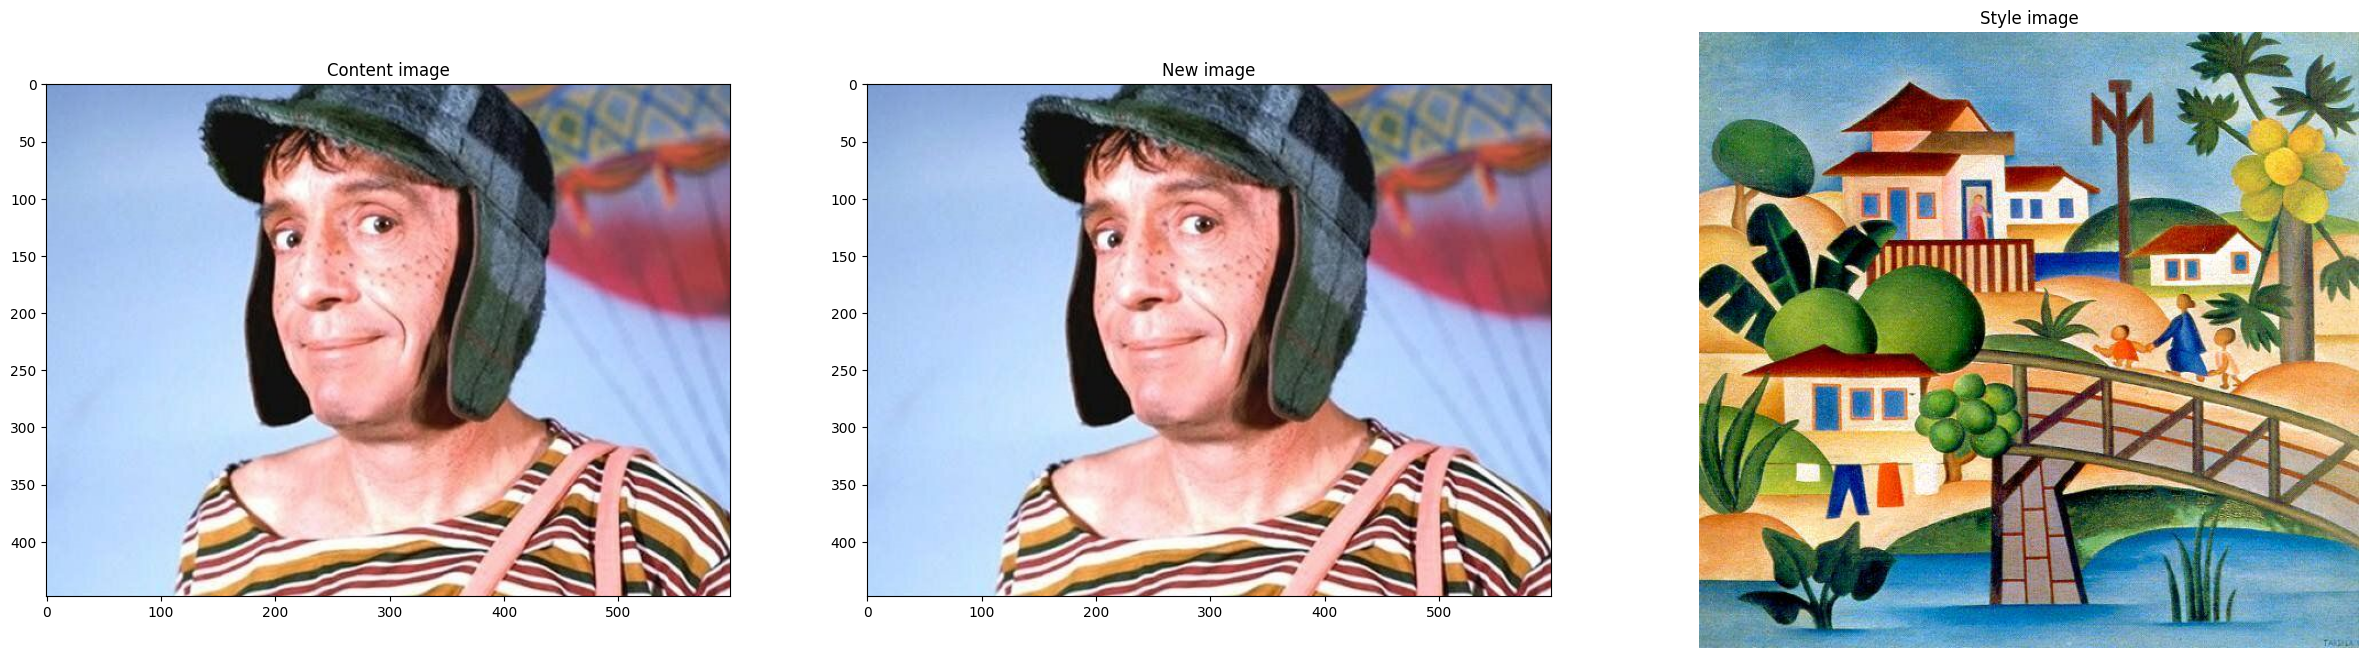

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,8))
ax1.imshow(tf.squeeze(content_image, axis = 0))
ax1.set_title('Content image')
ax2.imshow(tf.squeeze(new_image))
ax2.set_title('New image')
ax3.imshow(tf.squeeze(style_image))
ax3.set_title('Style image')
plt.axis('off');